# **Chap4：循环神经网络RNN**

In [3]:
import tensorflow as tf
from matplotlib import pyplot as plt
import jieba
from tqdm import tqdm
import time
import numpy as np
from source.code import ch4
from source.code import utils

In [2]:
utils.gpu_limitation_config(device=0,memory=30)

## **4.3 现代循环神经网络模型**

### **4.3.1 门控循环单元 GRU**

在设计 RNN 模型和对序列的建模时，思考下面的几个场景：
* 有的序列中**早期观测值**（序列头部）对预测未来观测值有非常重要的意义，但 RNN 模型从序列头部开始接收每个观测 $x_t$ 来更新隐藏状态 $h_t$，到序列末尾时，头部的关键信息 $h_1,h_2$ 可能几乎已经被“丢弃”了，这种现象称为**隐藏状态遗忘**，我们希望有**某些机制能够存储重要的早期信息**
* 序列中的**部分词元对任务目标没有实际含义**，例如对网页内容进行情感分析，在爬取的网页文本中可能有**辅助的 HTML 代码**，这些**文本与网页传达的情绪无关**，因此我们希望**某些机制能够过滤这些无意义词元**，模型在处理它们时**跳过隐状态更新**
* 有时**序列各个部分之间存在逻辑中断**，例如两个段落之间可能会有过渡存在，当这种情况发生时，我们希望**某些机制能够重置我们的隐藏状态表示**

学术界已经提出了许多方法来解决这类问题，最早的方法是使用**长短期记忆**（long-short-term memory，**LSTM**），由于该方法相对复杂，我们在稍后介绍，本节先介绍稍简单一些的**门控循环单元**（gated recurrent unit，**GRU**），它通常能提供与 LSTM 相同的效果，且计算速度相对更快

GRU 与普通 RNN 之间的关键区别在于：
* GRU 支持隐状态的门控，模型有专门的机制确认应该**何时更新隐状态**，以及**何时重置隐状态**
* **这些机制作为模型的参数，是可学习的**

有了门控单元后，模型可以实现上述三种机制：
* 遇到一个重要的词后，模型之后不再更新隐状态
* 模型可以学会跳过不相关、不重要的临时观测
* 模型可以学会在需要的时候重置隐状态

**(1) 重置门和更新门**

首先介绍**重置门**（reset gate）和**更新门**（update gate），我们把它们设计为 $(0,1)$ 区间中的向量，这样就可以利用它们的凸组合：
* 重置门允许我们**控制可能还想记住**的过去状态的数量
* 更新门允许我们**控制新状态中**有多少比例是来自于旧的状态

下图是 GRU 中重置门和更新门的输入和计算
* 输入包含当前时间步的观测 $X_t$ 和上一步隐藏状态 $H_{t-1}$
* 两个门的输出都是**使用 sigmoid 激活函数的全连接神经网络**，将输出变换到区间 $(0,1)$ 范围

<img src="./source/Chap4/重置门和更新门.svg" width=500>

对于给定时间步 $t$，设 $X_t\in\mathbb{R}^{n\times p}$，$H_{t-1}\in\mathbb{R}^{n\times h}$，那么重置门 $R_t$ 和更新门 $Z_t$ 可以表示为：
$$
R_t = \sigma\left( X_t W_{xr} + H_{t-1}W_{hr} + b_r \right) \\
Z_t = \sigma\left( X_t W_{xz} + H_{t-1}W_{hz} + b_z \right) \\
$$

其中，$W_{xr}, W_{xz}\in\mathbb{R}^{p\times h}$，$W_{hr}, W_{hz}\in\mathbb{R}^{h\times h}$ 是权重参数，$b_r,b_z\in\mathbb{R}^h$ 是偏置，$\sigma$ 表示 sigmoid 激活函数

**(2) 候选隐藏状态**

接下来，将重置门 $R_t$ 与隐状态运算，得到**候选隐藏状态** $\hat{H}_t \in\mathbb{R}^{n\times h}$：
$$
\hat{H}_t = \text{tanh}\left( X_t W_{xh} + (R_t \otimes H_{t-1})W_{hh} + b_h \right)
$$

其中 $W_{xh}\in\mathbb{R}^{p\times h}, W_{hh}\in\mathbb{R}^{h\times h}$ 是权重参数，$b_h\in\mathbb{R}^h$ 是偏置，$\otimes$ 表示 **Hardamard积**，即**按元素的乘积运算**，我们用 $\text{tanh}$ **激活函数确保候选隐藏状态中的值保持在** $(-1,1)$ 之间

对比原始 RNN 中隐状态的更新公式：
$$
H_t = \phi(X_tW_{xh} + H_{t-1}W_{hh} + b_h)
$$

重置门 $R_t$ 与 $H_{t-1}$ 元素相乘**可以减少过去状态的影响**
* 当 $R_t$ 中元素趋于 1 时，重置门不起作用，候选隐藏状态 $\hat{H}_t$ 接近通常的 RNN 隐藏状态 $H_t$
* 当 $R_t$ 中元素趋于 0 时，候选隐藏状态是以 $X_t$ 为输入的激活结果，**丢弃过去历史的记忆** $H_{t-1}$，起到**重置作用**

下图展示了候选隐藏状态 $\hat{H}_t$ 的计算逻辑

<img src="./source/Chap4/重置门的计算.svg" width=700>

**(3) 隐状态**

$\hat{H}_t$ 只是**候选隐藏状态**，真正的隐藏状态 $H_t$ 还需要**更新门** $Z_t$ 的参与：
$$
H_t = Z_t\otimes H_{t-1} + (1 - Z_t)\otimes \hat{H}_t
$$

这一步确定新的隐藏状态 $H_t$ **在多大程度上来自旧的状态** $H_{t-1}$ 和**新的候选状态** $\hat{H}_t$，因此我们用 $Z_t$ **构造了一个凸组合实现这个更新过程**
* 当 $Z_t$ 中元素趋于 1 时，模型倾向于**只保留旧的状态**，此时来自 $X_t$ 的信息（由 $\hat{H}_t$ 携带）基本上被忽略，从而**有效跳过了依赖链条中的时间步** $t$
* 当 $Z_t$ 中元素趋于 0 时，**候选状态** $\hat{H}_t$ **直接成为新的隐藏状态**

上述这些设计可以帮助我们（**处理 RNN 中的梯度消失问题**，并**更好地捕获时间步距离很长的序列的依赖关系**
* 思考，对于长为 $T$ 的一个序列，如果让模型记住一开始的输入 $X_1$，**更新门应该怎么做能将信息一直传递到序列末尾**？

<img src="./source/Chap4/更新门的计算.svg" width=700>

总结 GRU 中的重置门和更新门，其特点是：
* **重置门有助于捕获序列中的短期依赖关系**，即 $H_t$ 与 $X_t$ 的依赖
* **更新门有助于捕获序列中的长期依赖关系**，即 $H_t$ 与 $H_{t-1}$ 的依赖

接下来我们动手实现一下 GRU 模型，以更清晰了解每个计算过程发生了什么，我们依然延续 RNN 模型的定义逻辑

首先，定义 GRU 模型所需要的模型参数

In [3]:
def get_gru_params(embed_size : int, vocab_size : int, num_hiddens : int):
    # 输入维度 p 等于词嵌入维度 embed_size
    # 输出维度 o 等于词典大小 vocab_size
    num_inputs = embed_size
    num_outputs = vocab_size

    # 正态分布初始化参数
    def normal(shape):
        return tf.random.normal(
            shape=shape, stddev=0.01, mean=0, dtype=tf.float32)
    
    # 重置门，更新门，候选隐藏状态参数
    # 都包含三部分参数
    def three():
        return (
            tf.Variable(normal((num_inputs, num_hiddens))),
            tf.Variable(normal((num_hiddens, num_hiddens))),
            tf.Variable(tf.zeros(num_hiddens, dtype=tf.float32)),
        )
    
    W_xr, W_hr, b_r = three()  # 重置门参数
    W_xz, W_hz, b_z = three()  # 更新门参数
    W_xh, W_hh, b_h = three()  # 候选隐藏状态参数

    # 输出层的参数
    W_ho = tf.Variable(normal((num_hiddens, num_outputs)))
    b_o = tf.Variable(tf.zeros(num_outputs, dtype=tf.float32))
    
    params = [W_xr, W_hr, b_r, 
              W_xz, W_hz, b_z, 
              W_xh, W_hh, b_h, 
              W_ho, b_o]
    return params

接下来，初始化隐藏状态

In [4]:
def init_gru_state(batch_size : int, num_hiddens : int):
    H = tf.zeros(shape=(batch_size, num_hiddens))
    return (H, )

然后，定义 GRU 的计算逻辑

In [8]:
def gru(inputs : tf.Tensor, state : tf.Tensor, params : list):
    """
    Parameters
    ----------
    inputs : tf.Tensor
        输入，形状为 (num_steps, batch_size, embed_size)
    state : tf.Tensor
        隐藏状态，每个的形状为 (batch_size, num_hiddens)
    params : list
        RNN 参数列表
    
    Returns
    -------
    outputs : tf.Tensor
        输出，形状为 (num_steps * batch_size, vocab_size)
    state : tf.Tensor
        更新后的隐藏状态，每个的形状为 (batch_size, num_hiddens)
    """

    # 重置门，更新门，候选隐藏状态参数
    W_xr, W_hr, b_r, W_xz, W_hz, b_z, W_xh, W_hh, b_h, W_ho, b_o = params
    H, = state

    outputs = []
    for X in inputs:
        # X 形状为 (batch_size, embed_size)
        # H 形状为 (batch_size, num_hiddens)
        R = tf.sigmoid(X @ W_xr + H @ W_hr + b_r) # 重置门
        Z = tf.sigmoid(X @ W_xz + H @ W_hz + b_z) # 更新门
        H_hat = tf.tanh(X @ W_xh + (H * R) @ W_hh + b_h) # 候选隐藏状态
        # 隐藏状态
        H = Z * H + (1 - Z) * H_hat

        # 输出
        Y = H @ W_ho + b_o
        Y = tf.nn.softmax(Y, axis=1) # 得到概率分布
        outputs.append(Y)
    return tf.concat(outputs, axis=0), (H, )

模型的创建可以使用 **4.2** 节中的接口 `RNNBlockScratch`
* 我们只需要更改接口参数`init_state`，`rnn_func`和`get_params`

In [11]:
# 输入形状 (batch_size, num_steps)
batch_size, num_steps = 2, 5
X = tf.reshape(tf.range(batch_size*num_steps), (batch_size, num_steps))

# 嵌入，词表大小，隐藏层大小
embed_size, vocab_size, num_hiddens= 8, 28, 16

# 创建模型
model = ch4.RNNBlockScratch(
    embed_size, vocab_size, num_hiddens, 
    init_state=init_gru_state, rnn_func=gru, get_params=get_gru_params
)

In [12]:
# 获取初始隐藏状态
state = model.begin_state(X.shape[0])
print("初始时隐藏状态数量：", len(state))
print("初始时隐藏状态形状：", state[0].shape)

Y, new_state = model(X, state)

# 查看输出形状
print("输出形状：", Y.shape)
print("隐藏状态数量：", len(new_state))
print("隐藏状态形状：", new_state[0].shape)

初始时隐藏状态数量： 1
初始时隐藏状态形状： (2, 16)
输出形状： (10, 28)
隐藏状态数量： 1
隐藏状态形状： (2, 16)


在实际使用中，我们还是推荐利用 `Tensorflow` 提供的 API 实现，它在计算逻辑上经过优化，速度更快

In [14]:
def create_gru_model(num_hiddens : int, embed_size : int, vocab_size : int):
    gru_cell = tf.keras.layers.GRUCell(num_hiddens,kernel_initializer='glorot_uniform')
    gru_layer = tf.keras.layers.RNN(
        gru_cell, time_major=True, return_sequences=True, return_state=True)
    model = ch4.RNNModel(gru_layer, embed_size, vocab_size)

    return model

我们来测试一下模型的训练和预测效果

In [15]:
# 导入词表迭代器
train_iter = ch4.SeqDataLoader(
    file="./source/data/text/余华作品集.txt",token="char", concat=True,
    num_lines=50000, batch_size=128, num_steps=32, use_random_iter=True
)
vocab = train_iter.vocab

# 计算语料库大小
if isinstance(train_iter.corpus[0], list):
    corpus_size = sum(len(c) for c in train_iter.corpus)
else:
    corpus_size = len(train_iter.corpus)
print("语料库大小：", corpus_size)

# 实例化模型
model = ch4.create_gru_model(num_hiddens=512, embed_size=64, vocab_size=len(vocab))

100%|██████████| 31692/31692 [00:00<00:00, 709687.47it/s]


语料库大小： 864985


平均 726758.0 词元/秒


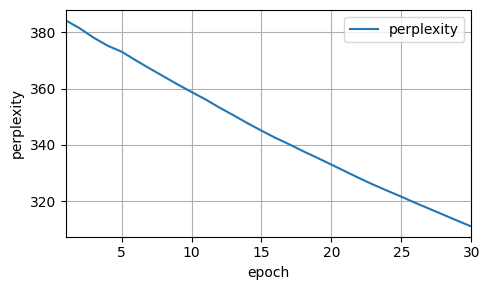

In [20]:
model = ch4.train_text_generation(model,train_iter=train_iter,use_random_iter=True,Epochs=30,verbose=1)

In [21]:
prefix = [
    "今天天气真好，我想",
    "太阳从西边出来了，"
]
for p in prefix:
    print(ch4.chinese_text_predict(p, 10, model, vocab))

今天天气真好，我想是我们的，他们的，他
太阳从西边出来了，他们的，他们的，他们


### **4.3.2 长短期记忆网络 LSTM**

**解决隐变量模型存在着长期信息保存和短期输入缺失的问题**的最早方法是**长短期存储器**（LSTM），它具有很多与 GRU 相似的性质，但要比 GRU 稍微复杂一些

LSTM 设计的**灵感来源于计算机的逻辑门**，并除了隐状态外，引入了新的变量**记忆元**（memory cell），它可以当作**另一种隐藏状态**，并与隐状态有相同的形状

**(1) 输入门，忘记门和输出门**

与 GRU 的重置门和更新门设计类似，时间步 $t$ 的观测 $X_t$ 和上一时刻的隐藏状态 $H_{t-1}$ 输入给模型**计算门控单元**，只不过此时我们需要输入门 $I_t$，遗忘门 $F_t$，输出门 $O_t$ 来设计门控单元，如下图所示：

<img src="./source/Chap4/LSTM的门控单元.svg" width=600>

对于给定时间步 $t$，设 $X_t\in\mathbb{R}^{n\times p}$，$H_{t-1}\in\mathbb{R}^{n\times h}$，$I_t, F_t, O_t$ 表示为：
$$
I_t = \sigma(X_tW_{xi} + H_{t-1} W_{hi} + b_i) \\
F_t = \sigma(X_tW_{xf} + H_{t-1} W_{hf} + b_f) \\
O_t = \sigma(X_tW_{xo} + H_{t-1} W_{ho} + b_o) \\
$$

$W_{xi}, W_{xf},W_{xo}\in\mathbb{R}^{p\times h}, W_{hi}, W_{hf},W_{ho}\in\mathbb{R}^{h\times h}$ 表示权重，$b_i,b_f,b_o\in\mathbb{R}^h$ 表示偏置

**(2) 候选记忆元**

LSTM 将 RNN 一次隐藏状态的更新记为**候选记忆元** $\hat{C}_t$，激活函数使用 $\text{tanh}$，将数值映射到 $(-1,1)$：
$$
\hat{C}_t = \text{tanh}(X_t W_{xc} + H_{t-1}W_{hc} + b_c)
$$

其中，$W_{xc}\in\mathbb{R}^{p\times h}, W_{hc}\in\mathbb{R}^{h\times h}$

下图展示了候选记忆元的计算，事实上**计算逻辑与前面三个门控是相同的**

<img src="./source/Chap4/候选记忆元.svg" width=600>

**(3) 记忆元**

记忆元 $C_t$ 与隐藏状态 $H_t$ 一样需要更新，我们用输入门 $I_t$ 和遗忘门 $F_t$ 来实现记忆元的更新：
$$
C_t = F_t \otimes C_{t-1} + I_t\otimes \hat{C}_t
$$

$F_t,I_t$ 控制新的记忆元的构成，有多少来自上一个记忆元 $C_{t-1}$，有多少来自新的候选记忆元 $\hat{C}_t$：
* 如果 $F_t \to 1, I_t\to 0$，则过去的记忆元 $C_{t-1}$ 随着时间保存并传递到 $C_t$，这可以**缓解梯度消失**，并更好让模型**捕获长序列中远距离外的依赖关系**

<img src="./source/Chap4/LSTM记忆元.svg" width=700>

**(4) 隐藏状态**

最后，使用记忆元 $C_t$ 和输出门 $O_t$ 用于计算真正的隐藏状态 $H_t$：
$$
H_t = O_t\otimes \text{tanh}(C_t)
$$

$\text{tanh}$ 激活使得隐藏状态 $H_t$ 的值始终在 $(-1,1)$ 之间：
* 如果 $O_t\to 1$，则模型就**能将有效的记忆** $C_t$ **传递给预测输出的部分**
* 如果 $O_t\to 0$，我们就**只保留记忆** $C_t$，但重置隐藏状态 $H_t$，不会传递给预测输出的部分

<img src="./source/Chap4/LSTM隐藏状态.svg" width=700>

可以看到 LSTM 模型中，记忆元和隐藏状态 $C_t,H_t$ 是**双路计算**的，这也是为什么我们**在之前代码的实现中**，**保持** `state` **变量是一个列表 / 元组的原因**，因为在 LSTM 中实现中，`state` 将包含两个变量

与 RNN，GRU 的实现类似，我们分别定义 `get_lstm_params()`, `init_lstm_state()` 和 `lstm()` 三个函数

In [25]:
def get_lstm_params(embed_size : int, vocab_size : int, num_hiddens : int):
    # 输入维度 p 等于词嵌入维度 embed_size
    # 输出维度 o 等于词典大小 vocab_size
    num_inputs = embed_size
    num_outputs = vocab_size

    # 正态分布初始化参数
    def normal(shape):
        return tf.random.normal(
            shape=shape, stddev=0.01, mean=0, dtype=tf.float32)
    
    # 重置门，更新门，候选隐藏状态参数
    # 都包含三部分参数
    def three():
        return (
            tf.Variable(normal((num_inputs, num_hiddens))),
            tf.Variable(normal((num_hiddens, num_hiddens))),
            tf.Variable(tf.zeros(num_hiddens, dtype=tf.float32)),
        )
    
    W_xi, W_hi, b_i = three() # 输入门参数
    W_xf, W_hf, b_f = three() # 遗忘门参数
    W_xo, W_ho, b_o = three() # 输出门参数
    W_xc, W_hc, b_c = three() # 候选记忆元参数

    # 输出层的参数
    W_hq = tf.Variable(normal((num_hiddens, num_outputs)))
    b_q = tf.Variable(tf.zeros(num_outputs, dtype=tf.float32))
    
    params = [W_xi, W_hi, b_i, 
              W_xf, W_hf, b_f, 
              W_xo, W_ho, b_o, 
              W_xc, W_hc, b_c, 
              W_hq, b_q]
    return params

In [26]:
def init_lstm_state(batch_size : int, num_hiddens : int):
    H = tf.zeros(shape=(batch_size, num_hiddens),dtype=tf.float32)
    C = tf.zeros(shape=(batch_size, num_hiddens),dtype=tf.float32)
    # 注意，LSTM 的隐藏状态包含两个元素
    return (H, C)

In [31]:
def lstm(inputs : tf.Tensor, state : tuple, params : list):
    # 获取参数
    W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c, W_hq, b_q = params
    H, C = state # 隐藏状态和记忆元

    outputs = []
    for X in inputs:
        # X 形状为 (batch_size, embed_size)
        # H 形状为 (batch_size, num_hiddens)
        # C 形状为 (batch_size, num_hiddens)
        I = tf.sigmoid(X @ W_xi + H @ W_hi + b_i) # 输入门
        F = tf.sigmoid(X @ W_xf + H @ W_hf + b_f) # 遗忘门
        O = tf.sigmoid(X @ W_xo + H @ W_ho + b_o) # 输出门
        C_hat = tf.tanh(X @ W_xc + H @ W_hc + b_c) # 候选记忆元
        C = F * C + I * C_hat # 记忆元
        H = O * tf.tanh(C) # 隐藏状态
        
        # 输出
        Y = H @ W_hq + b_q # 输出
        Y = tf.nn.softmax(Y, axis=1)
        outputs.append(Y)
    # 注意，LSTM 的隐藏状态需要返回两个元素
    return tf.concat(outputs, axis=0), (H, C)

继续使用 `RNNBlockScratch` 可以测试 LSTM 模型，将 `init_state`, `rnn_func`, `get_params` 参数修改为刚才定义的 LSTM 模型的函数

In [32]:
# 输入形状 (batch_size, num_steps)
batch_size, num_steps = 2, 5
X = tf.reshape(tf.range(batch_size*num_steps), (batch_size, num_steps))

# 嵌入，词表大小，隐藏层大小
embed_size, vocab_size, num_hiddens= 8, 28, 16

# 创建模型
model = ch4.RNNBlockScratch(
    embed_size, vocab_size, num_hiddens, 
    init_state=init_lstm_state, rnn_func=lstm, get_params=get_lstm_params
)

In [33]:
# 获取初始隐藏状态
state = model.begin_state(X.shape[0])
print("初始时隐藏状态数量：", len(state))
print("初始时隐藏状态形状：", state[0].shape)

Y, new_state = model(X, state)

# 查看输出形状
print("输出形状：", Y.shape)
print("隐藏状态数量：", len(new_state))
print("隐藏状态形状：", new_state[0].shape)

初始时隐藏状态数量： 2
初始时隐藏状态形状： (2, 16)
输出形状： (10, 28)
隐藏状态数量： 2
隐藏状态形状： (2, 16)


利用 `Tensorflow` 的 API 也可以非常简单的定义 LSTM 模型

In [34]:
# 创建 LSTM 模型
def create_lstm_model(num_hiddens : int, embed_size : int, vocab_size : int):
    lstm_cell = tf.keras.layers.LSTMCell(num_hiddens,kernel_initializer='glorot_uniform')
    lstm_layer = tf.keras.layers.RNN(
        lstm_cell,time_major=True, return_sequences=True, return_state=True)
    model = ch4.RNNModel(lstm_layer, embed_size, vocab_size)
    return model

接下来创建模型，进行训练，查看训练效果

In [36]:
# 导入词表迭代器
train_iter = ch4.SeqDataLoader(
    file="./source/data/text/余华作品集.txt",token="char", concat=True,
    num_lines=50000, batch_size=128, num_steps=32, use_random_iter=True
)
vocab = train_iter.vocab

# 计算语料库大小
if isinstance(train_iter.corpus[0], list):
    corpus_size = sum(len(c) for c in train_iter.corpus)
else:
    corpus_size = len(train_iter.corpus)
print("语料库大小：", corpus_size)

# 实例化模型
model = ch4.create_lstm_model(num_hiddens=512, embed_size=64, vocab_size=len(vocab))

100%|██████████| 31692/31692 [00:00<00:00, 292669.67it/s]


语料库大小： 864985


平均 917537.0 词元/秒


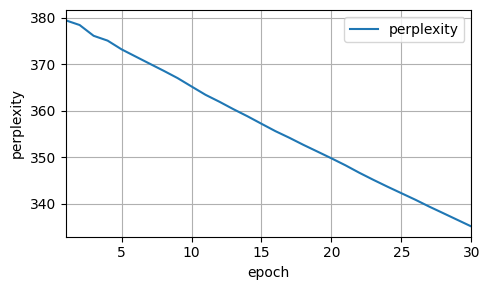

In [44]:
model = ch4.train_text_generation(model,train_iter=train_iter,use_random_iter=True,Epochs=30,verbose=1)

In [45]:
prefix = [
    "今天天气真好，我想",
    "太阳从西边出来了，"
]
for p in prefix:
    print(ch4.chinese_text_predict(p, 10, model, vocab))

今天天气真好，我想，他们的，我是是我的
太阳从西边出来了，他们的，他们的，他们


### **4.3.3 深度循环神经网络**

到目前为止，我们只讨论了**具有一个单隐藏层的循环神经网络**，对于一个单层网络而言，其拟合能力有限，在之前的多层感知机模型中，我们通过添加更多的层来解决这个问题，如果**想要在 RNN 中使用多层思想，我们应该明确如何添加更多的层**

事实上，我们可以**将多层循环神经网络堆叠在一起**，通过对几个简单层的组合，提升模型的拟合能力，下图展示了一个具有 $L$ 层隐藏层的**深度循环神经网络**，注意**每个隐藏状态都连续地传递给当前层的下一个时间步和下一层当前时间步**

<img src="./source/Chap4/深度RNN.svg" width=400>

下面我们来形式化深度循环神经网络的计算过程，设时间步 $t$ 有输入 $X_t\in\mathbb{R}^{n\times p}$（批量样本数 $n$，特征维度为 $p$），同时，将 $l=1,2,\cdots,L$ 层隐藏层的隐藏状态设为 $H_t^{(l)}\in\mathbb{R}^{n\times h}$（隐藏神经元个数为 $h$），输出层为 $O_t\in\mathbb{R}^{n\times o}$，我们设 $H_t^{(0)} = X_t$ 作为第0 层隐藏层，则：

$$
H_t^{(l)} = \phi(H_t^{(l-1)}W_{xh}^{(l)} + H_{t-1}^{(l)}W_{hh}^{(l)} + b_h^{(l)})
$$

其中，$W_{xh}^{(l)},W_{hh}^{(l)}\in\mathbb{R}^{h\times h},b_h^{(l)}\in\mathbb{R}^h$ 是第 $l$ 层的模型参数

最后，**输出层的计算仅基于第** $L$ **个隐藏层（最后一层）最终的隐藏状态**：
$$
O_t = H_t^{(L)}W_{ho} + b_o
$$

其中，$W_ho\in\mathbb{R}^{h\times o},b_o\in\mathbb{R}^{o}$ 是输出层的参数

与多层感知机一样，隐藏层数目 $L$ 和隐藏单元数目 $h$ 都是**超参数**，此外 **GRU 和LSTM 也可以类似使用多层结构计算它们的隐藏状态或记忆元**

由于实现上没有太多区别，我们这里直接演示使用`Tensorflow` API 实现的多层循环神经网络
* 要**将多层的循环神经网络包装在一起**（包括`SimpleRNNCell`, `GRUCell`,`LSTMCell`），可以用 `StackedRNNCells`

In [2]:
# 创建两个隐藏层的 LSTM 模型
def create_multilayer_lstm_model(num_hiddens : int, num_layers : int, embed_size : int, vocab_size : int):
    lstm_cells = tf.keras.layers.StackedRNNCells([
        tf.keras.layers.LSTMCell(num_hiddens,kernel_initializer='glorot_uniform') for _ in range(num_layers)])
    lstm_layer = tf.keras.layers.RNN(
        lstm_cells, time_major=True, return_sequences=True, return_state=True)
    model = ch4.RNNModel(lstm_layer, embed_size, vocab_size)

    return model

In [3]:
# 批量大小，时间步数，隐藏层个数
batch_size, num_steps, num_layers = 2, 5, 3

# 嵌入，词表大小，隐藏层大小
embed_size, num_hiddens, vocab_size = 8, 32, 28

# 输入形状 (batch_size, num_steps)
X = tf.random.uniform(shape=(batch_size, num_steps))

# 创建模型
model = ch4.create_multilayer_lstm_model(num_hiddens, num_layers, embed_size, vocab_size)

In [4]:
# 获取初始隐藏状态
state = model.begin_state(batch_size=batch_size,dtype=tf.float32)
print("隐藏层数量：", len(state)) # 等于 num_layers
# LSTM 每层会包含两个隐藏状态，分别是隐藏状态 H 和记忆元 C
print("第一个隐藏层，隐藏状态数量：", len(state[0]))
print("第一个隐藏层，第一个隐藏状态形状：", state[0][0].shape)

# 进行推理
Y, new_state = model(X, state)

print("输出形状：", Y.shape)
print("更新后，隐藏层数量：", len(new_state)) # 等于 num_layers
# LSTM 每层会包含两个隐藏状态，分别是隐藏状态 H 和记忆元 C
print("更新后，第一个隐藏层，隐藏状态数量：", len(new_state[0]))
print("更新后，第一个隐藏层，第一个隐藏状态形状：", new_state[0][0].shape)

隐藏层数量： 3
第一个隐藏层，隐藏状态数量： 2
第一个隐藏层，第一个隐藏状态形状： (2, 32)
输出形状： (10, 28)
更新后，隐藏层数量： 3
更新后，第一个隐藏层，隐藏状态数量： 2
更新后，第一个隐藏层，第一个隐藏状态形状： (2, 32)


最后，训练一下深度循环神经网络，测试模型效果

In [5]:
# 导入词表迭代器
train_iter = ch4.SeqDataLoader(
    file="./source/data/text/余华作品集.txt",token="char", concat=True,
    num_lines=50000, batch_size=128, num_steps=32, use_random_iter=True
)
vocab = train_iter.vocab
# 实例化模型
model = ch4.create_multilayer_lstm_model(num_hiddens=512, num_layers=2, vocab_size=len(vocab), embed_size=64)

100%|██████████| 31692/31692 [00:00<00:00, 264107.07it/s]


平均 508014.0 词元/秒


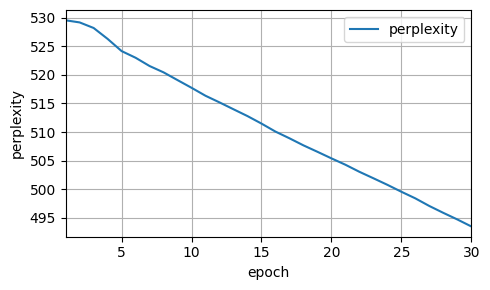

In [12]:
model = ch4.train_text_generation(model,train_iter=train_iter,use_random_iter=True,Epochs=30,verbose=1)

In [13]:
prefix = [
    "今天天气真好，我想",
    "太阳从西边出来了，"
]
for p in prefix:
    print(ch4.chinese_text_predict(p, 10, model, vocab))

今天天气真好，我想，，，，，他，，他，
太阳从西边出来了，，，，他，他，他，，


### **4.3.4 双向循环神经网络**

在之前的序列建模任务中，我们都是假设**给定历史的观测序列，对未来下一个输出进行预测**，这虽然是典型场景，但显然序列任务还有更多其他类型，例如：
* **完形填空**：我___饿了，我可以干五碗饭
* **机器翻译**："今天天气不错，适合骑车" -> (`English`)

在这些序列建模的场景中，我们不再是单纯的依赖上文给出下文：
* 完形填空中，每个短语的**下文**传达了重要信息
  * 而之前的 RNN 模型**只能看到空缺部分前的上文**，没有下文信息的序列模型在这类任务上表现不好
* 机器翻译中，当前翻译**目标语言输出的词可能需要观察源语句的完整句子**，以理解语境
  * 例如对 `Green` 进行翻译时，是翻译为"绿色"，还是指代"格林先生"，一定需要上下文信息，而之前的 RNN 模型只能简单的从左到右顺序处理序列，看不到下文的信息

为了引出**双向循环神经网络**（Bidirectional RNN)，我们先来看一下**隐马尔可夫模型**（Hidden Markov Model，简称**HMM**）的计算问题，我们用某个隐状态 $h_t$ 对观测 $x_t$ 建模，得到 $x_t\sim P(x_t|h_t)$，并且隐状态存在概率转移 $h_t\to h_{t+1}$，通过 $P(h_{t+1}|h_t)$ 对该转移过程建模，如下图所示：
* 注意，**该部分内容与模型本身无关，但能帮助理解模型计算和设计的思想**

<img src="./source/Chap4/HMM.svg" width=400>

因此，对于长度为 $T$ 的一个观测序列，我们对观测状态和隐状态有如下的联合概率：
$$
P(x_1,\cdots,x_T,h_1,\cdots,h_T) = \prod_{t=1}^{T} P(h_t|h_{t-1})P(x_t|h_t),\quad P(h_1|h_0) = P(h_1)
$$

在完形填空的例子中，假设我们观察到除 $x_j$ 外的所有序列，目标是计算 $P(x_j | x_{-j})$，其中 $x_{-j} = (x_1,\cdots,x_{j-1},x_{j+1},\cdots,x_T)$，由于 $P(x_j|x_{-j})$ 不包含隐状态，我们考虑对 $h_1,\cdots,h_T$ **包含的所有可能状态求和**
* 如果每个 $h_i$ 有 $k$ 个可能的取值，这意味着我们的求和项有 $k^T$ 个，**这个指数级的任务难于登天**

但利用**动态规划**求和技巧，可以很快把任务难度降低到多项式复杂度上来：

$$
\begin{split}\begin{aligned}
    &P(x_1, \ldots, x_T) \\
    =& \sum_{h_1, \ldots, h_T} P(x_1, \ldots, x_T, h_1, \ldots, h_T) \\
    =& \sum_{h_1, \ldots, h_T} \prod_{t=1}^T P(h_t \mid h_{t-1}) P(x_t \mid h_t) \\
    =& \sum_{h_2, \ldots, h_T} \underbrace{\left[\sum_{h_1} P(h_1) P(x_1 \mid h_1) P(h_2 \mid h_1)\right]}_{\pi_2(h_2) \stackrel{\mathrm{def}}{=}}
    P(x_2 \mid h_2) \prod_{t=3}^T P(h_t \mid h_{t-1}) P(x_t \mid h_t) \\
    =& \sum_{h_3, \ldots, h_T} \underbrace{\left[\sum_{h_2} \pi_2(h_2) P(x_2 \mid h_2) P(h_3 \mid h_2)\right]}_{\pi_3(h_3)\stackrel{\mathrm{def}}{=}}
    P(x_3 \mid h_3) \prod_{t=4}^T P(h_t \mid h_{t-1}) P(x_t \mid h_t)\\
    =& \dots \\
    =& \sum_{h_T} \pi_T(h_T) P(x_T \mid h_T).
\end{aligned}\end{split}
$$

动态规划利用 $\pi_t(h_t)$ 来计算 $\pi_{t+1}(h_{t+1})$，上述这种**前向递归**的计算式写为：
$$
\pi_{t+1}(h_{t+1}) = \sum_{h_t} \pi_t(h_t) P(x_t | h_t)P(h_{t+1} | h_t)
$$

**递归的初始化设定为** $\pi_1(h_1) = P(h_1)$，我们可以将这个递归关系符号化为 $\pi_{t+1}=f(\pi_t,x_t)$，其中 $f$ 是可学习函数，这就**转换到了我们在 RNN 模型中讨论的更新方程了**

与**前向递归类似**，上面概率的计算也可以**从后向前递归进行**，得到：

$$
\begin{split}\begin{aligned}
    & P(x_1, \ldots, x_T) \\
     =& \sum_{h_1, \ldots, h_T} P(x_1, \ldots, x_T, h_1, \ldots, h_T) \\
    =& \sum_{h_1, \ldots, h_T} \prod_{t=1}^{T-1} P(h_t \mid h_{t-1}) P(x_t \mid h_t) \cdot P(h_T \mid h_{T-1}) P(x_T \mid h_T) \\
    =& \sum_{h_1, \ldots, h_{T-1}} \prod_{t=1}^{T-1} P(h_t \mid h_{t-1}) P(x_t \mid h_t) \cdot
    \underbrace{\left[\sum_{h_T} P(h_T \mid h_{T-1}) P(x_T \mid h_T)\right]}_{\rho_{T-1}(h_{T-1})\stackrel{\mathrm{def}}{=}} \\
    =& \sum_{h_1, \ldots, h_{T-2}} \prod_{t=1}^{T-2} P(h_t \mid h_{t-1}) P(x_t \mid h_t) \cdot
    \underbrace{\left[\sum_{h_{T-1}} P(h_{T-1} \mid h_{T-2}) P(x_{T-1} \mid h_{T-1}) \rho_{T-1}(h_{T-1}) \right]}_{\rho_{T-2}(h_{T-2})\stackrel{\mathrm{def}}{=}} \\
    =& \ldots \\
    =& \sum_{h_1} P(h_1) P(x_1 \mid h_1)\rho_{1}(h_{1}).
\end{aligned}\end{split}
$$

因此，我们可以定义**后向递归**：
$$
\rho_{t-1}(h_{t-1}) = \sum_{h_t} P(h_t | h_{t-1}) P(x_t | h_t) \rho_t(h_t)
$$

将最后时刻的初始化为 $\rho_T(h_T) = 1$，**前向和后向递归允许我们对** $T$ **长度的序列在** $\mathcal{O}(kT)$ **时间内完成计算**，将计算复杂度从指数减少为线性，后向递归也可以符号化为 $\rho_{t-1} = g(\rho_t,x_t)$，其中 $g$ 是一个可以学习的函数，这**非常像 RNN 的更新方程**，只不过**它将循环神经网络中看到的前向运算，改为后向计算**

结合前向和后向递归，我们能够计算：
$$
P(x_j | x_{-j}) \propto \sum_{h_j} \pi_j(h_j) \rho_j(h_j) P(x_j | h_j)
$$

在很多实践问题中，**知道未来数据可用对隐马尔可夫模型是有益的**

如果我们希望在 RNN 中拥有一种机制，使之能够提供上述讨论的**前瞻能力**，看到序列的下文， 我们需要稍微修改 RNN 的结构，事实上，实现该过程非常简单，我们**只需要增加一个**“**从最后一个词元开始从后向前运行**”的循环神经网络，**双向循环神经网络添加了反向传递信息的隐藏层**，以获得前瞻能力，如下图所示：

<img src="./source/Chap4/双向RNN.svg" width=500>

接下来，我们将计算逻辑形式化，对于任意时间步 $t$，给定输入 $X_t\in\mathbb{R}^{n\times p}$，在双向 RNN 中，我们设该时间步的前向和反向隐藏状态分别为 $\overrightarrow{H}_t\in\mathbb{R}^{n\times h},\overleftarrow{H}_t\in\mathbb{R}^{n\times h}$，前向和反向隐状态的更新如下：
$$
\overrightarrow{H}_t = \phi(X_t W_{xh}^{(f)} + \overrightarrow{H}_{t-1}W_{hh}^{(f)} + b_h^{(f)}) \\
\overleftarrow{H}_t = \phi(X_t W_{xh}^{(b)} + \overleftarrow{H}_{t+1}W_{hh}^{(b)} + b_h^{(b)}) \\
$$

其中，$W_{xh}^{(f)}, W_{hh}^{(f)}, W_{xh}^{(b)}, W_{hh}^{(b)}\in\mathbb{R}^{h\times h}$ 是权重参数，$b_h^{(f)}, b_h^{(b)}\in\mathbb{R}^h$ 是偏置参数

将输出层的处理上，我们将前向和后向隐藏状态拼接起来，获得隐状态 $H_t$：
$$
H_t = [\overrightarrow{H}_t; \overleftarrow{H}_t] \in\mathbb{R}^{n\times 2h}
$$

如果考虑的是**具有多个隐藏层的深度双向循环神经网络**，则隐藏状态 $H_t$ 会作为信息传入下一个双向层，最后输出 $O_t\in\mathbb{R}^{n\times o}$ 为：
$$
O_t = H_tW_{ho} + b_o
$$

其中，$W_{ho}\in\mathbb{R}^{2h\times o}, b_o\in\mathbb{R}^o$ 是输出层的权重和偏置，事实上，**前向和后向隐藏状态可以有不同大小的神经元**，例如 $h_1,h_2$，但实际操作中大家不会这么做

最后，我们对双向 RNN 说明以下几点：
* 双向的思路可以非常简单的扩展到 GRU，LSTM
* **双向 RNN 使用来自序列两端的信息来估计输出**，也就是说，我们**使用来自过去和未来的观测信息来预测当前的观测**，在**对下一个词元进行预测**的任务中，**双向 RNN 模型并不是我们所需的**
  * 因为在预测下一个词元时，我们终究无法知道下一个词元的下文是什么
  * 具体的问题出现在，在**训练期间**，我们能够利用过去和未来的数据来估计现在空缺的词（**变成了完形填空任务**），而在**测试期间**，我们只有过去的数据，因此精度将会很差
* 另一个问题是，**双向循环神经网络的计算速度非常慢**，因为网络的推理需要在双向层中进行前向和后向递归，而梯度更新时反向传播依赖于网络推理的结果，因此**梯度求解将有一个非常长的链**
* 双向层的使用在实践中比较少，仅在特定任务中使用，例如：
  * 完形填空
  * 词元注释（例如解释每个词的词性，每个词指代的命名实体判断）
  * 机器翻译任务中，将源语句进行编码

在`Tensorflow`中，使用 `tf.keras.layers.Bidirectional`将一个 `RNN` 模型包装起来，就可以实现双向循环神经网络了

In [11]:
# 创建两个隐藏层的 LSTM 模型
def create_bidirectional_lstm_model(num_hiddens : int, embed_size : int, vocab_size : int):
    lstm_cell = tf.keras.layers.LSTMCell(num_hiddens,kernel_initializer='glorot_uniform')
    lstm_layer = tf.keras.layers.RNN(
        lstm_cell, time_major=True, return_sequences=True, return_state=True)
    # 用 Bidirectional 包装 RNN 模型
    bi_rnn = tf.keras.layers.Bidirectional(lstm_layer)
    model = ch4.RNNModel(bi_rnn, embed_size, vocab_size)

    return model

In [12]:
# 批量大小，时间步数，隐藏层个数
batch_size, num_steps = 2, 5

# 嵌入，词表大小，隐藏层大小
embed_size, num_hiddens, vocab_size = 8, 32, 28

# 输入形状 (batch_size, num_steps)
X = tf.random.uniform(shape=(batch_size, num_steps))

# 创建模型
model = ch4.create_bidirectional_lstm_model(num_hiddens, embed_size, vocab_size)

In [13]:
# 获取初始隐藏状态
state = model.begin_state(batch_size=batch_size,dtype=tf.float32)
print("隐藏状态数量：", len(state))
# LSTM 前向和后向各有两个隐藏状态，分别是隐藏状态 H 和记忆元 C
print("前向隐藏状态形状：", state[0].shape)
print("后向记忆元形状：", state[3].shape)

# 进行推理
Y, new_state = model(X, state)

print("输出形状：", Y.shape)
print("更新后，隐藏状态数量：", len(new_state))
print("更新后，前向隐藏状态形状：", new_state[0].shape)
print("更新后，后向记忆元形状：", new_state[3].shape)

隐藏状态数量： 4
前向隐藏状态形状： (2, 32)
后向记忆元形状： (2, 32)
输出形状： (10, 28)
更新后，隐藏状态数量： 4
更新后，前向隐藏状态形状： (2, 32)
更新后，后向记忆元形状： (2, 32)


如果我们**去掉网络最后的输出层**，仅计算循环神经网络的输出，可以观察到此时**输出的维度等于两倍隐藏层的大小**，即 $2h$

In [16]:
# 嵌入输出
X_embed = model.embedding(tf.transpose(X)) # 注意交换时间步和批量维度
rnn_output, *state = model.rnn(X_embed, state)

# 形状为 (num_steps, batch_size, 2*num_hiddens)
print("RNN 层输出形状：", rnn_output.shape) 

RNN 层输出形状： (5, 2, 64)


### **一个错误的演示**

我们将创建的双向循环神经网络用于前面演示的文本预测任务，这是一个**错误的演示**，因为**双向循环神经网络使用了过去的和未来的数据**，所以我们**不能盲目地将这一语言模型应用于任何预测任务**
* 在训练时，尽管模型的困惑度是合理的，但在预测时，你会发现该模型预测未来词元的能力可能存在严重缺陷

In [17]:
# 导入词表迭代器
train_iter = ch4.SeqDataLoader(
    file="./source/data/text/余华作品集.txt",token="char", concat=True,
    num_lines=50000, batch_size=128, num_steps=32, use_random_iter=True
)
vocab = train_iter.vocab
# 实例化模型
model = create_bidirectional_lstm_model(num_hiddens=512, vocab_size=len(vocab), embed_size=64)

100%|██████████| 31692/31692 [00:00<00:00, 719148.02it/s]


平均 1604978.0 词元/秒


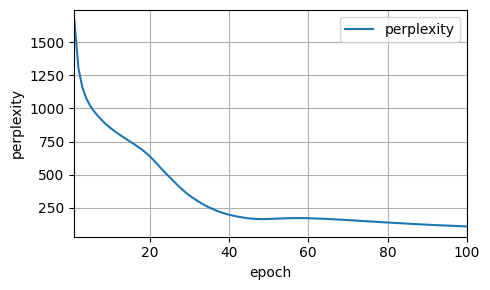

In [18]:
model = ch4.train_text_generation(model,train_iter=train_iter,use_random_iter=True,Epochs=100,verbose=1)

In [19]:
prefix = [
    "今天天气真好，我想",
    "太阳从西边出来了，"
]
for p in prefix:
    print(ch4.chinese_text_predict(p, 10, model, vocab))

今天天气真好，我想想想想想想想想想想想
太阳从西边出来了，铜厉s漫礼礼礼礼礼礼


----

### **练习**

1. **分别说明对于 GRU 和 LSTM**，模型想要实现以下机制，各个门控的元素应该如何设计：
   1. 在时间步 $t$，遗忘之前历史序列的所有信息，只保留通过观测 $X_t$ 获得的隐藏状态
   2. 在时间步 $t$，不更新过去隐藏状态保存的信息，忽略观测 $X_t$ 带来的新信息

    1. 对GRU，让重置门趋于0，更新门也趋于0；对LSTM，让遗忘门趋于0，输入门趋于1，输出门也趋于1
    2. 对GRU，让更新门趋于1，重置门趋于1；对LSTM，让遗忘门趋于1，输入门趋于0，输出门趋于1

2. 创建一个具有**两个隐藏层的深度 GRU 模型**，利用在 `./source/code/ch4_hw.py` 中定义的接口，利用文本 `./source/data/text/time_traveller.txt` 进行训练，并测试模型效果

----